In [1]:
!ls ../caueeg/

abnormal-no-overlap.json annotation.xlsx          dementia.json
abnormal.json            conn_data                event
annotation.json          dementia-no-overlap.json signal


In [2]:
import json
f = open('../caueeg/abnormal.json')
data_files = json.load(f)
f.close()

In [3]:
data_files["train_split"][0]

{'serial': '01258',
 'age': 77,
 'symptom': ['dementia', 'vd', 'sivd'],
 'class_name': 'Abnormal',
 'class_label': 1}

In [4]:
idx2label = {}
for file_idx in data_files["train_split"]:
    idx2label[file_idx["serial"]] = file_idx["class_label"]
for file_idx in data_files["test_split"]:
    idx2label[file_idx["serial"]] = file_idx["class_label"]
for file_idx in data_files["validation_split"]:
    idx2label[file_idx["serial"]] = file_idx["class_label"]

In [5]:
len(data_files["train_split"])

1107

In [6]:
len(data_files["test_split"])

136

In [7]:
len(data_files["validation_split"])

136

In [8]:
import glob, os
files = []
for file in glob.glob("../caueeg/signal/edf/*.edf"):
    files.append(file)
print(len(files))

1379


In [9]:
import glob, os
test_data_files = []
for file_name in data_files["test_split"]:
    test_data_files.append("../caueeg/signal/edf/"+file_name["serial"]+".edf")
print(len(test_data_files))

train_data_files = []
for file_name in data_files["train_split"]:
    train_data_files.append("../caueeg/signal/edf/"+file_name["serial"]+".edf")
for file_name in data_files["validation_split"]:
    train_data_files.append("../caueeg/signal/edf/"+file_name["serial"]+".edf")
print(len(train_data_files))

136
1243


In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.module import Module
from sklearn.preprocessing import OneHotEncoder

/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import mne
import numpy as np

file = train_data_files[0]
data = mne.io.read_raw(file, verbose=False, preload=True)

data.filter(l_freq=0.5, h_freq=47, verbose=False)
data = mne.make_fixed_length_epochs(data, duration=1, overlap=0, verbose=False)
ch_names = data.ch_names
data = data.get_data()*1e6
data.shape

Using data from preloaded Raw for 917 events and 200 original time points ...
0 bad epochs dropped


(917, 21, 200)

In [12]:
import mne
from tqdm import tqdm
from statsmodels.tsa.stattools import grangercausalitytests
import random
import numpy as np
from scipy.signal import savgol_filter
from scipy import signal
import cv2
from numpy import *
from scipy.stats import iqr
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.signal import medfilt
from scipy.stats import differential_entropy, norm
from scipy import fftpack
import antropy as ant


def calcGrangerCausality(eegData,ii,jj):
    #eegData = np.diff(eegData)
    gc_avg = []
    for epoch_idx, epoch in enumerate(eegData):
        if epoch_idx%2 == 0:
            X = np.vstack([epoch[ii,:],epoch[jj,:]]).T
            gc = grangercausalitytests(X, 1, addconst=True, verbose=False)[1][0]['ssr_ftest'][0]
            gc_avg.append(gc)
    gc_avg = np.mean(gc_avg)
    return gc_avg

def get_label(file):
    idx = file.split("/")[-1][:-4]
    label = idx2label[idx]
    if label == 0:
        return [0]
    elif label == 1:
        return [1]


def lyapunov(x):
    return np.mean(np.log(np.abs(np.gradient(x))))


def build_data(raw_data, cal_conn=False, bands=False):
    
    eeg_data = []
    labels = []
    lengths = []
    groups = []
    i = 0
    fs = 100
    
    data_features = []
    data_labels = []
    data_graphs = []
    
    for file in tqdm(raw_data):
        
        #get label
        label = get_label(file)
        data_labels.append(label)
        
        #node features
        sample_features = []
        data = mne.io.read_raw(file, verbose=False, preload=True)
        ch_names = data.ch_names
        data.resample(sfreq=100)
        data.filter(l_freq=0.5, h_freq=40, verbose=False).resample(sfreq=fs)
        data_epochs = mne.make_fixed_length_epochs(data, duration=1, overlap=0, verbose=False)
        data = data.get_data()#[:, :20000]
        data_epochs = data_epochs.get_data()
        if data_epochs.shape[0] > 100:
            data_epochs = data_epochs[:100]
        
        
        if cal_conn:
            gc = []
            for i in range(21):
                gc1 = []
                for j in range(21):
                    gc1.append(calcGrangerCausality(data_epochs, i, j))
                gc.append(gc1)
        
            gc1 = (np.array(gc) + np.array(gc).T)/2
            gc2 = (np.array(gc) - np.array(gc).T)/2
            data_graphs.append([gc1, gc2])    
        
        
        ch_features = []    
        # freq domain features
        sf = 256
        win = 4 * sf # win size 4 seconds * sampling freq
        # delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–13 Hz), beta (13–30 Hz), and gamma (30–... Hz).
        freq_ranges = [[0.5, 4], [4, 8], [8, 13], [13, 30], [30, 47]]
        for ch in data:
            
            ch_features.append(differential_entropy(ch))
        
            ly = lyapunov(ch)
            ch_features.append(ly)
        
            entropy = ant.perm_entropy(ch, normalize=True)
            ch_features.append(entropy)
        
            entropy = ant.spectral_entropy(ch, sf=100, method='welch', normalize=True)
            ch_features.append(entropy)
        
            mobility = ant.hjorth_params(ch)
            ch_features.append(mobility[0])
            ch_features.append(mobility[1])
        
            zero_cross_count = ant.num_zerocross(ch)
            ch_features.append(zero_cross_count)
            
            
            if bands:
                # freq domain features
                for freq_band in freq_ranges:
                
                    # differential entropy
                    sos = signal.butter(10, (freq_band[0], freq_band[1]), 'bandpass', fs=1000, output='sos')
                    filtered_ch = signal.sosfilt(sos, ch) 
                    ch_features.append(differential_entropy(filtered_ch))

                    # lyapunov features
                    ch_features.append(lyapunov(filtered_ch))

                    # Permutation entropy
                    entropy = ant.perm_entropy(filtered_ch, normalize=True)
                    ch_features.append(entropy)

                    # Spectral entropy
                    entropy = ant.spectral_entropy(filtered_ch, sf=100, method='welch', normalize=True)
                    ch_features.append(entropy)

                    # Hjorth mobility and complexity
                    mobility = ant.hjorth_params(filtered_ch)
                    ch_features.append(mobility[0])
                    ch_features.append(mobility[1])

                    corr = np.correlate(filtered_ch, filtered_ch)
                    ch_features.append(corr[0])

                    # Number of zero-crossings
                    zero_cross_count = ant.num_zerocross(filtered_ch)
                    ch_features.append(zero_cross_count)

                    # power spectrum
                    freqs, psd = signal.welch(ch, sf, nperseg=win)
                    idx_freq_band = np.logical_and(freqs >= freq_band[0], freqs < freq_band[1])
                    # Frequency resolution
                    freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25
                    # Compute the absolute power by approximating the area under the curve
                    band_power = simps(psd[idx_freq_band], dx=freq_res)
                    #power_band_.append(band_power)
                    ch_features.append(band_power)
                
            
            sample_features.append(ch_features)
            ch_features = []
            
        data_features.append(sample_features)
        
    data_features = np.array(data_features)
    data_labels = np.array(data_labels)
    data_graphs = np.array(data_graphs)
    
    return data_features, data_graphs, data_labels

In [482]:
%%capture
np.random.seed(42)
train_X, train_graphs, train_y = build_data(train_data_files)
test_X, test_graphs, test_y = build_data(test_data_files)

In [113]:
test_X.shape, train_X.shape, train_graphs.shape, test_y.shape, train_y.shape, test_graphs.shape

((136, 21, 52),
 (1243, 21, 52),
 (1243, 2, 21, 21),
 (136, 1),
 (1243, 1),
 (136, 2, 21, 21))

In [83]:
import copy

def uniform_all_data(train_graphs, test_graphs):
    out_train = copy.deepcopy(train_graphs)
    out_test = copy.deepcopy(test_graphs)

    
    min_A = train_graphs.min()
    max_A = train_graphs.max()
    out_train = (train_graphs - min_A)/(max_A - min_A)
    out_test = (test_graphs - min_A)/(max_A - min_A)

    return out_train, out_test


def uniform_separate_A(train_graphs):
    out_normalized = copy.deepcopy(train_graphs)

    for i, A in enumerate(train_graphs):
        
        for j, feat in enumerate(A):
            min_A = train_graphs[i, j].min()
            max_A = train_graphs[i, j].max()
    
            out_normalized[i, j] = (train_graphs[i, j] - min_A)/(max_A - min_A)

    return out_normalized

import copy

def uniform(graphs):
    out = copy.deepcopy(graphs)

    min_A = graphs.min()
    max_A = graphs.max()
    out = (graphs - min_A)/(max_A - min_A)

    return out

In [82]:
#np.save("../caueeg_features/conn_data/gc/train_X.npy", train_X)
#np.save("../caueeg_features/conn_data/gc/test_X.npy", test_X)
#np.save("../caueeg_features/conn_data/gc/train_y.npy", train_y)
#np.save("../caueeg_features/conn_data/gc/test_y.npy", test_y)
#np.save("../caueeg_features/conn_data/gc/train_graphs1.npy", train_graphs)
#np.save("../caueeg_features/conn_data/gc/test_graphs1.npy", test_graphs)

train_X = np.load("../caueeg_features/conn_data/gc/train_X.npy")
test_X = np.load("../caueeg_features/conn_data/gc/test_X.npy")
train_y = np.load("../caueeg_features/conn_data/gc/train_y.npy")
test_y = np.load("../caueeg_features/conn_data/gc/test_y.npy")
train_graphs = np.load("../caueeg_features/conn_data/gc/train_graphs1.npy")
test_graphs = np.load("../caueeg_features/conn_data/gc/test_graphs1.npy")


In [549]:
#train_graphs = uniform_separate_A(train_graphs)
#test_graphs = uniform_separate_A(test_graphs)

#train_graphs.min(), train_graphs.max()

In [84]:
train_graphs, test_graphs = uniform_all_data(train_graphs, test_graphs)
#train_graphs1, test_graphs1 = uniform_all_data(train_graphs[:, 0], test_graphs[:, 0])
#train_graphs2, test_graphs2 = uniform_all_data(train_graphs[:, 1], test_graphs[:, 1])

# here we check if the two matrices are symmetric
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

print(check_symmetric(train_graphs[0, 0]), check_symmetric(train_graphs[0, 1]))

import networkx as nx
test_graphs_normalized = []
train_graphs_normalized = []

for graph in test_graphs:
    graph_normalized = []
    for graph_feat in graph:
        graph_feat = nx.Graph(graph_feat)
        graph_normalized.append(nx.normalized_laplacian_matrix(graph_feat).toarray())
    test_graphs_normalized.append(graph_normalized)
for graph in train_graphs:
    graph_normalized = []
    for graph_feat in graph:
        graph_feat = nx.Graph(graph_feat)
        graph_normalized.append(nx.normalized_laplacian_matrix(graph_feat).toarray())
    train_graphs_normalized.append(graph_normalized)               

train_graphs = np.array(train_graphs_normalized)  
test_graphs = np.array(test_graphs_normalized)  

test_graphs.min(), test_graphs.max(), train_graphs.min(), train_graphs.max()

True False


(-0.07528492609181447,
 0.9648155827782534,
 -0.09881203062077881,
 0.9694773151885153)

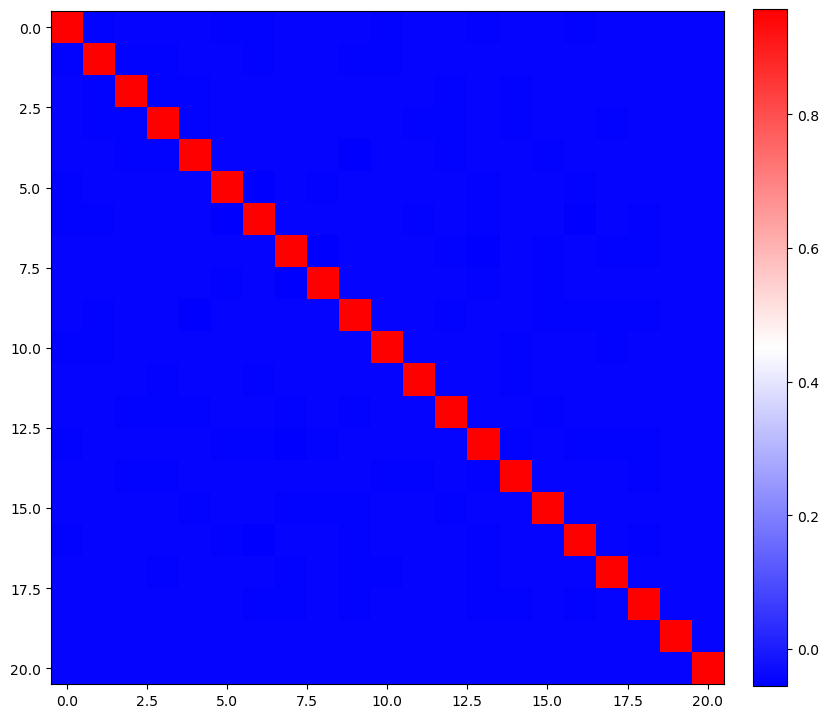

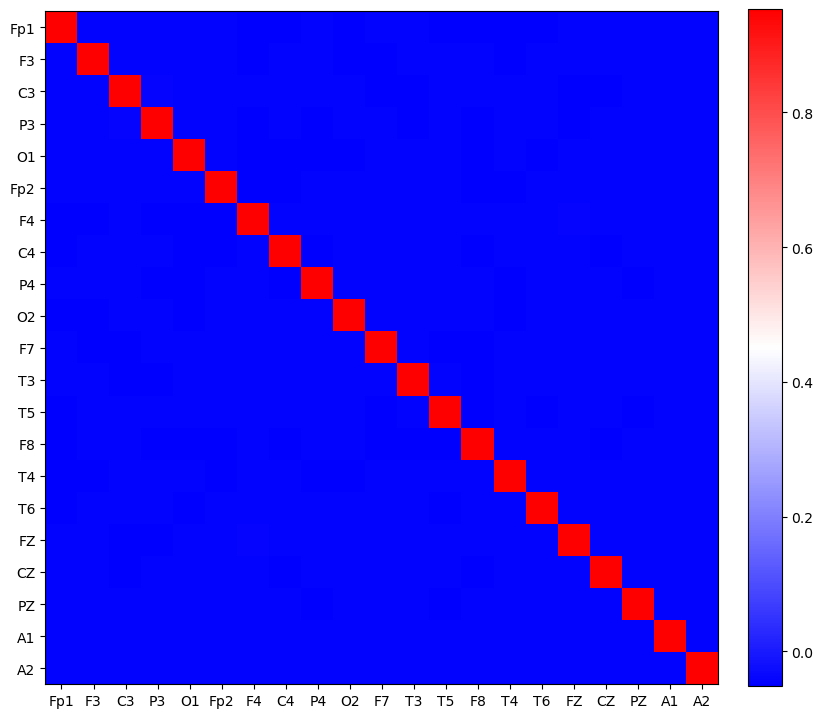

label:  [1]


In [552]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(9.5,9.5))
fig2, ax2 = plt.subplots(figsize=(9.5,9.5))

# create an index for each tick position
my_xticks = ch_names_renamed
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[6, 0], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)

im2 = ax2.imshow(train_graphs[6, 1], cmap='bwr', interpolation='nearest')
fig2.colorbar(im2, orientation='vertical', fraction=0.046, pad=0.04)
#fig.savefig("abnormal2.pdf", bbox_inches='tight')

plt.show()

print("label: ", train_y[6])

In [16]:
# here we check if the laplacians of the two matrices are symmetric
print(check_symmetric(train_graphs[6, 0]), check_symmetric(train_graphs[6, 1]))

True True


In [17]:
ch_names_renamed = []
for ch in ch_names[:-2]:
    ch_names_renamed.append(ch[:-4])
ch_names_renamed.extend(["A1", "A2"])

In [18]:
import torch

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import copy

def data_loader(features, graphs, labels, device, batch_size, shuffle=True):
    features, graphs, labels = torch.Tensor(features), torch.Tensor(graphs), torch.Tensor(labels)
    data = torch.utils.data.TensorDataset(features, graphs, labels)
    del features
    del labels
    data_iter = torch.utils.data.DataLoader(data, batch_size, shuffle=shuffle)
    del data
    return data_iter

def standardize_data(train_X, test_X):
 
    train_X_std = copy.deepcopy(train_X)
    test_X_std = copy.deepcopy(test_X)
    
    for i in tqdm(range(train_X.shape[1])):
        for j in range(train_X.shape[2]):
            min_ = np.min(train_X[:, i, j])
            max_ = np.max(train_X[:, i, j])
            train_X_std[:, i, j] = (train_X[:, i, j] - min_)/(max_ - min_)
            test_X_std[:, i, j] = (test_X[:, i, j] - min_)/(max_ - min_)

    return train_X_std, test_X_std

In [85]:
train_X = np.load("../caueeg_features/conn_data/gc/train_X.npy")
test_X = np.load("../caueeg_features/conn_data/gc/test_X.npy")
train_y = np.load("../caueeg_features/conn_data/gc/train_y.npy")
test_y = np.load("../caueeg_features/conn_data/gc/test_y.npy")
train_graphs = np.load("../caueeg_features/conn_data/gc/train_graphs1.npy")
test_graphs = np.load("../caueeg_features/conn_data/gc/test_graphs1.npy")
train_graphs1, test_graphs1 = uniform_all_data(train_graphs[:, 0], test_graphs[:, 0])
train_graphs2, test_graphs2 = uniform_all_data(train_graphs[:, 1], test_graphs[:, 1])

train_graphs = np.sum((train_graphs1, train_graphs2), axis=0)
test_graphs = np.sum((test_graphs1, test_graphs2), axis=0)
#train_graphs, test_graphs = uniform_all_data(train_graphs, test_graphs)
train_X, test_X = standardize_data(train_X, test_X)

100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 3693.25it/s]


In [86]:
train_X.max(), test_X.max(), train_X.min(), test_X.min()

(1.0, 1.0445493456293193, 0.0, -0.11878684040599256)

In [79]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, auc, roc_auc_score

def evaluate_model(model, loss_func, data_iter):
    model.eval()
    loss_sum, n = 0, 0
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred,y)
            loss_sum += loss.item()
            n += 1
        return loss_sum / n
    
def cal_accuracy(model, data_iter):
    ytrue = []
    ypreds = []
    y_score = []
    model.eval()
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            yhat = model(x, A)
            
            yhat_labels = np.argmax(yhat, -1)
            y_labels = np.argmax(y, -1)
            
            y_score.extend(np.max(F.softmax(yhat, dim=1).numpy(), -1))
            ytrue.extend(list(y_labels.numpy()))
            ypreds.extend([int(yhat_i) for yhat_i in yhat_labels])
    
    return (accuracy_score(ytrue, ypreds), 
            confusion_matrix(ytrue, ypreds), 
            precision_score(ytrue, ypreds, zero_division=0), 
            recall_score(ytrue, ypreds, zero_division=0),
            f1_score(ytrue, ypreds,  zero_division=0))

# GC

In [87]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_max_pool
import networkx as nx


def normalize_A(A):
    norm = []
    A1 = (A + A.T)/2
    A2 = (A - A.T)/2
    A1 = uniform(A1)
    A2 = uniform(A2)
    for graph_feat in [A1, A2]:
        graph_feat = nx.Graph(graph_feat)
        norm.append(nx.normalized_laplacian_matrix(graph_feat).toarray())
    
    return norm


def normalize_all_A(A):
    
    A = A.detach().numpy()
    all_A = []
    for adj in A:
        all_A.append(normalize_A(adj))
    all_A = np.array(all_A)
    all_A = torch.tensor(all_A)
    return all_A


class ChebNetConv(nn.Module):
    def __init__(self, in_features, out_features, k):
        super(ChebNetConv, self).__init__()

        self.K = k
        self.linear = nn.Linear(in_features * k, out_features)

    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        x = self.__transform_to_chebyshev(x, laplacian)
        x = self.linear(x)
        
        return x

    def __transform_to_chebyshev(self, x, laplacian):
        cheb_x = x.unsqueeze(2)
        x0 = x
        if self.K > 1:
            x1 = torch.matmul(laplacian, x0)
            cheb_x = torch.cat((cheb_x, x1.unsqueeze(2)), 2)
            for _ in range(2, self.K):
                x2 = 2 * torch.matmul(laplacian, x1) - x0
                cheb_x = torch.cat((cheb_x, x2.unsqueeze(2)), 2)
                x0, x1 = x1, x2
        cheb_x = cheb_x.reshape(cheb_x.shape[0], cheb_x.shape[1], cheb_x.shape[2]*cheb_x.shape[3])
        return cheb_x

    
import torch.nn.functional as F


class ChebNetGCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, 
                 num_classes, num_hidden_layers=2, dropout=0, residual=False, k=2):
        super(ChebNetGCN, self).__init__()

        self.dropout = dropout
        self.residual = residual

        self.input_conv = ChebNetConv(input_size, hidden_size, k)
        self.hidden_convs = nn.ModuleList([ChebNetConv(hidden_size, hidden_size, k) for _ in range(num_hidden_layers)])
        self.output_conv = ChebNetConv(hidden_size, out_channels, k)
        self.BN1 = nn.BatchNorm1d(out_channels*2)
        self.fc = nn.Linear(out_channels*2, num_classes)
        
    def forward(self, x: torch.Tensor, A: torch.sparse_coo_tensor, edge_weight=None):
        if edge_weight is not None:
            A = edge_weight * A
            
        laplacians = normalize_all_A(A)
        
        laplacian1,laplacian2 = laplacians[:, 0].float(), laplacians[:, 1].float()
        #print(laplacian1.shape,laplacian2.shape, laplacian1[0])
        #laplacian1 = laplacian1 + laplacian2
        x1 = F.relu(self.input_conv(x, laplacian1))
        x2 = F.relu(self.input_conv(x, laplacian2))
        #print(x.shape)
        for conv in self.hidden_convs:
            if self.residual:
                x1 = F.relu(conv(x1, laplacian1)) + x1
                x2 = F.relu(conv(x2, laplacian2)) + x2
            else:
                x1 = F.relu(conv(x1, laplacian1))
                x2 = F.relu(conv(x2, laplacian2))
        #print(x.shape)        
        #x1 = F.dropout(x1, p=self.dropout, training=self.training)
        x1 = self.output_conv(x1, laplacian1)
        #x2 = F.dropout(x2, p=self.dropout, training=self.training)
        x2 = self.output_conv(x2, laplacian2)
        #print(x.shape)
        x1 = x1.squeeze()
        #x = x1
        x2 = x2.squeeze()
        #print(x1.shape,x2.shape)
        x = torch.cat((x1, x2), dim=-1)
        #x = x1 + x2
        #print(x.shape)
        batch =None
        x = global_mean_pool(x, batch)
        #print(x.shape)
        x = self.BN1(x)
        x = self.fc(x)
        #print(x.shape)
        return x

In [95]:
#%%capture
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
#from model import ChebNetGCN


NUM_EPOCHS = 400
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

loss_func = nn.CrossEntropyLoss()

all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []

skf = KFold(n_splits=5, shuffle=True)
skf.get_n_splits(train_X, train_y)

print("Training Model....")
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    
    model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_X_subset = train_X[train_index]
    train_y_subset = train_y[train_index]
    train_graphs_subset = train_graphs[train_index]
    val_X = train_X[val_index]
    val_y = train_y[val_index]
    val_graphs_subset = train_graphs[val_index]

    encoder = OneHotEncoder()
    train_y_subset = encoder.fit_transform(train_y_subset).toarray()
    val_y = encoder.transform(val_y).toarray()

    train_iter = data_loader(train_X_subset ,train_graphs_subset, train_y_subset, DEVICE, BATCH_SIZE, shuffle=True)
    val_iter = data_loader(val_X, val_graphs_subset, val_y, DEVICE, BATCH_SIZE, shuffle=False)

    kfold_train_loss = []
    kfold_val_loss = []
    kfold_train_f1 = []
    kfold_val_f1 = []
    for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss#.item()
            loss.backward()
            optimizer.step()

        train_loss = evaluate_model(model, loss_func, train_iter)
        val_loss = evaluate_model(model, loss_func, val_iter)
        train_f1 = cal_accuracy(model, train_iter)[-1]
        val_f1 = cal_accuracy(model, val_iter)[-1]
        kfold_train_loss.append(train_loss)
        kfold_val_loss.append(val_loss)
        kfold_train_f1.append(train_f1)
        kfold_val_f1.append(val_f1)

    all_train_losses.append(kfold_train_loss)
    all_val_losses.append(kfold_val_loss)
    all_train_f1.append(kfold_train_f1)
    all_val_f1.append(kfold_val_f1)

Training Model....


  0%|                                         | 1/400 [00:16<1:48:00, 16.24s/it]


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


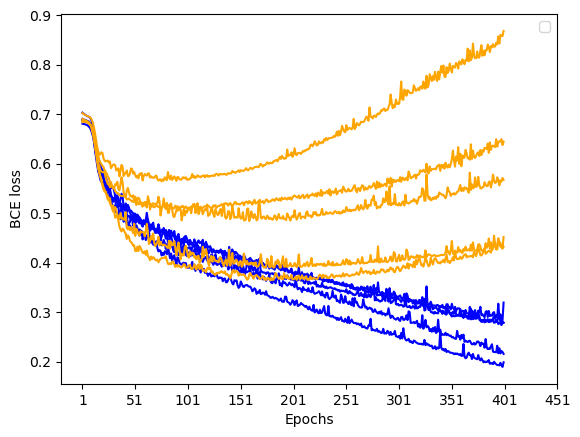

In [27]:
import matplotlib.pyplot as plt

all_val_losses = np.moveaxis(np.array(all_val_losses), 0, 1)
all_train_losses = np.moveaxis(np.array(all_train_losses), 0, 1)
plt.plot(all_train_losses, color='blue')
plt.plot(all_val_losses, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 500, 50), range(1, 501, 50))
plt.ylabel("BCE loss")
plt.legend(loc="upper right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


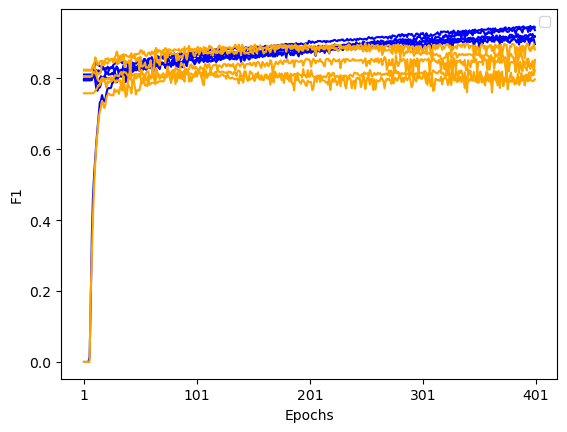

In [28]:
all_val_f1 = np.moveaxis(np.array(all_val_f1), 0, 1)
all_train_f1 = np.moveaxis(np.array(all_train_f1), 0, 1)
plt.plot(all_train_f1, color='blue')
plt.plot(all_val_f1, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 500, 100), range(1, 501, 100))
plt.ylabel("F1")
plt.legend(loc="upper right")
plt.show()

In [100]:
#%%capture
from tqdm import tqdm
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
#from model import ChebNetGCN

print("Training Model....")
NUM_EPOCHS = 130
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.fit_transform(test_y).toarray()
    
train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in range(1, NUM_EPOCHS + 1):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A = A.float()
        y_pred = model(x, A)
        loss = loss_func(y_pred, y)
        loss_sum += loss
        loss.backward()
        optimizer.step()
    test_acc = cal_accuracy(model, test_iter)
    train_acc = cal_accuracy(model, train_iter)
    print(epoch, train_acc[0], test_acc[0])

Training Model....
1 0.667739340305712 0.6617647058823529
2 0.667739340305712 0.6617647058823529
3 0.667739340305712 0.6617647058823529
4 0.667739340305712 0.6617647058823529
5 0.667739340305712 0.6617647058823529
6 0.66934835076428 0.6617647058823529
7 0.6967015285599356 0.7279411764705882
8 0.7240547063555913 0.7647058823529411
9 0.7055510860820595 0.7279411764705882
10 0.7047465808527755 0.6911764705882353
11 0.7063555913113435 0.7058823529411765
12 0.7135961383748994 0.7132352941176471
13 0.7184231697506034 0.7279411764705882
14 0.7240547063555913 0.7352941176470589
15 0.7337087691069992 0.7573529411764706
16 0.7465808527755431 0.7941176470588235
17 0.7457763475462591 0.8088235294117647
18 0.7401448109412712 0.8088235294117647
19 0.7465808527755431 0.8161764705882353
20 0.7377312952534192 0.7941176470588235
21 0.7401448109412712 0.7941176470588235
22 0.7208366854384554 0.75
23 0.7256637168141593 0.7794117647058824
24 0.7401448109412712 0.7867647058823529
25 0.7441673370876911 0.794

In [101]:
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Accuracy:  0.8382352941176471
Precision:  0.8617021276595744
Recall:  0.9
F1:  0.8804347826086957
Confusion Matrix:  [[33 13]
 [ 9 81]]


## Uncertainty Analysis

Here we run the model 20 times to record the stability

In [104]:
#%%capture
print("Training Model....")
import random
#from model import ChebNetGCN
NUM_EPOCHS = 130
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

test_accuaries = []
NUM_MODELS = 20

for model_idx in tqdm(range(NUM_MODELS)):
    seed = random.randint(0, 100000)
    torch.manual_seed(seed)
    model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    encoder = OneHotEncoder()
    train_y_ohe = encoder.fit_transform(train_y).toarray()
    test_y_ohe = encoder.fit_transform(test_y).toarray()

    train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
    test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)

    for epoch in range(1, NUM_EPOCHS + 1):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss
            loss.backward()
            optimizer.step()
            
    test_acc = cal_accuracy(model, test_iter)
    test_accuaries.append([test_acc[0], test_acc[2], test_acc[3], test_acc[4]])
test_accuaries = np.array(test_accuaries)

Training Model....


100%|████████████████████████████████████████| 20/20 [2:19:17<00:00, 417.87s/it]


In [105]:
print("Accuracy: ", test_accuaries[:, 0].std())
print("Precision: ", test_accuaries[:, 1].std())
print("Recall: ", test_accuaries[:, 2].std())
print("F1: ", test_accuaries[:, 3].std())

Accuracy:  0.018659672853602233
Precision:  0.012796498343135544
Recall:  0.03319880259628592
F1:  0.015701106863524994


In [106]:
print("Accuracy: ", test_accuaries[:, 0].mean())
print("Precision: ", test_accuaries[:, 1].mean())
print("Recall: ", test_accuaries[:, 2].mean())
print("F1: ", test_accuaries[:, 3].mean())

Accuracy:  0.8205882352941177
Precision:  0.8452024324517164
Recall:  0.8927777777777777
F1:  0.8679338122578869


## Corr

In [37]:
import numpy as np

def build_graphs(raw_data):
    
    fs = 100
    
    data_graphs = []
    
    for file in tqdm(raw_data):
        
        data = mne.io.read_raw(file, verbose=False, preload=True)
        ch_names = data.ch_names
        #data.resample(sfreq=100)
        data.filter(l_freq=0.5, h_freq=47, verbose=False)
        #data = mne.make_fixed_length_epochs(data, duration=5, overlap=1, verbose=False)
        data = data.get_data()*1e6
          
        corr = []
        for i in range(21):
            corr1 = []
            for j in range(21):
                corr1.append(np.correlate(data[i], data[j])[0])
            corr.append(corr1)
        data_graphs.append(corr)    
        
    data_graphs = np.array(data_graphs)
    
    return data_graphs

train_corr_graphs = build_graphs(train_data_files)
test_corr_graphs = build_graphs(test_data_files)

100%|█████████████████████████████████████████| 136/136 [00:14<00:00,  9.10it/s]


In [51]:
#np.save("../caueeg_features/conn_data/corr/train_graphs.npy", train_corr_graphs)
#np.save("../caueeg_features/conn_data/corr/test_graphs.npy", test_corr_graphs)

train_graphs = np.load("../caueeg_features/conn_data/corr/train_graphs.npy")
test_graphs = np.load("../caueeg_features/conn_data/corr/test_graphs.npy")

In [52]:
import copy

def uniform(train_graphs, test_graphs):
    out_train = copy.deepcopy(train_graphs)
    out_test = copy.deepcopy(test_graphs)

    min_A = train_graphs.min()
    max_A = train_graphs.max()
    out_train = (train_graphs - min_A)/(max_A - min_A)
    out_test = (test_graphs - min_A)/(max_A - min_A)

    return out_train, out_test

train_graphs, test_graphs = uniform(train_corr_graphs, test_corr_graphs)

In [53]:
import networkx as nx
test_graphs_normalized = []
train_graphs_normalized = []

for graph in test_graphs:
    graph = nx.Graph(graph)
    test_graphs_normalized.append(nx.normalized_laplacian_matrix(graph).toarray())
for graph in train_graphs:
    graph = nx.Graph(graph)
    train_graphs_normalized.append(nx.normalized_laplacian_matrix(graph).toarray())

train_graphs = np.array(train_graphs_normalized)  
test_graphs = np.array(test_graphs_normalized)  

test_graphs.min(), test_graphs.max(), train_graphs.min(), train_graphs.max()

(-0.09023545229533633,
 0.952380943275603,
 -0.2861318394186823,
 0.9523809354988071)

In [54]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_max_pool


class ChebNetConv(nn.Module):
    def __init__(self, in_features, out_features, k):
        super(ChebNetConv, self).__init__()

        self.K = k
        self.linear = nn.Linear(in_features * k, out_features)

    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        x = self.__transform_to_chebyshev(x, laplacian)
        x = self.linear(x)
        
        return x

    def __transform_to_chebyshev(self, x, laplacian):
        cheb_x = x.unsqueeze(2)
        x0 = x
        if self.K > 1:
            x1 = torch.matmul(laplacian, x0)
            cheb_x = torch.cat((cheb_x, x1.unsqueeze(2)), 2)
            for _ in range(2, self.K):
                x2 = 2 * torch.matmul(laplacian, x1) - x0
                cheb_x = torch.cat((cheb_x, x2.unsqueeze(2)), 2)
                x0, x1 = x1, x2
        cheb_x = cheb_x.reshape(cheb_x.shape[0], cheb_x.shape[1], cheb_x.shape[2]*cheb_x.shape[3])
        return cheb_x

    
import torch.nn.functional as F


class ChebNetGCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, 
                 num_classes, num_hidden_layers=2, dropout=0, residual=False, k=2):
        super(ChebNetGCN, self).__init__()

        self.dropout = dropout
        self.residual = residual

        self.input_conv = ChebNetConv(input_size, hidden_size, k)
        self.hidden_convs = nn.ModuleList([ChebNetConv(hidden_size, hidden_size, k) for _ in range(num_hidden_layers)])
        self.output_conv = ChebNetConv(hidden_size, out_channels, k)
        self.BN1 = nn.BatchNorm1d(out_channels)
        self.fc = nn.Linear(out_channels, num_classes)
        
    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor, edge_weight=None):
        if edge_weight is not None:
            laplacian = edge_weight * laplacian
        x = F.dropout(x, p=self.dropout, training=self.training)
        #print(x.shape)
        x = F.relu(self.input_conv(x, laplacian))
        #print(x.shape)
        for conv in self.hidden_convs:
            if self.residual:
                x = F.relu(conv(x, laplacian)) + x
            else:
                x = F.relu(conv(x, laplacian))
        #print(x.shape)        
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.output_conv(x, laplacian)
        #print(x.shape)
        x = x.squeeze()
        batch =None
        x = global_mean_pool(x, batch)
        #print(x.shape)
        x = self.BN1(x)
        x = self.fc(x)
        #print(x.shape)
        return x

In [61]:
#%%capture
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
#from model import ChebNetGCN


NUM_EPOCHS = 1000
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

loss_func = nn.CrossEntropyLoss()

all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []

skf = KFold(n_splits=5, shuffle=True)
skf.get_n_splits(train_X, train_y)

print("Training Model....")
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    
    model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_X_subset = train_X[train_index]
    train_y_subset = train_y[train_index]
    train_graphs_subset = train_graphs[train_index]
    val_X = train_X[val_index]
    val_y = train_y[val_index]
    val_graphs_subset = train_graphs[val_index]

    encoder = OneHotEncoder()
    train_y_subset = encoder.fit_transform(train_y_subset).toarray()
    val_y = encoder.transform(val_y).toarray()

    batch_size = 128
    train_iter = data_loader(train_X_subset ,train_graphs_subset, train_y_subset, DEVICE, BATCH_SIZE, shuffle=True)
    val_iter = data_loader(val_X, val_graphs_subset, val_y, DEVICE, BATCH_SIZE, shuffle=False)

    kfold_train_loss = []
    kfold_val_loss = []
    kfold_train_f1 = []
    kfold_val_f1 = []
    for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss#.item()
            loss.backward()
            optimizer.step()

        train_loss = evaluate_model(model, loss_func, train_iter)
        val_loss = evaluate_model(model, loss_func, val_iter)
        train_f1 = cal_accuracy(model, train_iter)[-1]
        val_f1 = cal_accuracy(model, val_iter)[-1]
        kfold_train_loss.append(train_loss)
        kfold_val_loss.append(val_loss)
        kfold_train_f1.append(train_f1)
        kfold_val_f1.append(val_f1)

    all_train_losses.append(kfold_train_loss)
    all_val_losses.append(kfold_val_loss)
    all_train_f1.append(kfold_train_f1)
    all_val_f1.append(kfold_val_f1)

Training Model....


100%|███████████████████████████████████████| 1000/1000 [01:59<00:00,  8.38it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


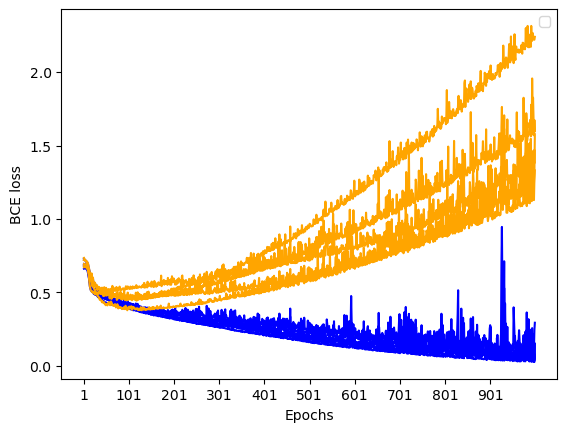

In [62]:
import matplotlib.pyplot as plt

all_val_losses = np.moveaxis(np.array(all_val_losses), 0, 1)
all_train_losses = np.moveaxis(np.array(all_train_losses), 0, 1)
plt.plot(all_train_losses, color='blue')
plt.plot(all_val_losses, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("BCE loss")
plt.legend(loc="upper right")
plt.show()

In [69]:
#%%capture
from tqdm import tqdm
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
#from model import ChebNetGCN


print("Training Model....")
NUM_EPOCHS = 150
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.fit_transform(test_y).toarray()
    
train_iter = data_loader(train_X, train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X, test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A = A.float()
        y_pred = model(x, A)
        loss = loss_func(y_pred, y)
        loss_sum += loss
        loss.backward()
        optimizer.step()

Training Model....


100%|█████████████████████████████████████████| 150/150 [00:12<00:00, 12.44it/s]


In [70]:
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Accuracy:  0.7941176470588235
Precision:  0.8297872340425532
Recall:  0.8666666666666667
F1:  0.8478260869565217
Confusion Matrix:  [[30 16]
 [12 78]]


## Stability of the model

In [71]:
#%%capture
print("Training Model....")
import random
NUM_EPOCHS = 150
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

test_accuaries = []
NUM_MODELS = 20

for model_idx in tqdm(range(NUM_MODELS)):
    seed = random.randint(0, 100000)
    torch.manual_seed(seed)
    model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    encoder = OneHotEncoder()
    train_y_ohe = encoder.fit_transform(train_y).toarray()
    test_y_ohe = encoder.fit_transform(test_y).toarray()

    train_iter = data_loader(train_X, train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
    test_iter = data_loader(test_X, test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)

    for epoch in range(1, NUM_EPOCHS + 1):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss
            loss.backward()
            optimizer.step()
            
    test_acc = cal_accuracy(model, test_iter)
    test_accuaries.append([test_acc[0], test_acc[2], test_acc[3], test_acc[4]])
test_accuaries = np.array(test_accuaries)

Training Model....


100%|███████████████████████████████████████████| 20/20 [02:51<00:00,  8.59s/it]


In [72]:
print("Accuracy: ", test_accuaries[:, 0].std())
print("Precision: ", test_accuaries[:, 1].std())
print("Recall: ", test_accuaries[:, 2].std())
print("F1: ", test_accuaries[:, 3].std())

Accuracy:  0.021997463678899414
Precision:  0.011973671270074546
Recall:  0.045849323809922876
F1:  0.019968976401759778


In [74]:
print("Accuracy: ", test_accuaries[:, 0].mean())
print("Precision: ", test_accuaries[:, 1].mean())
print("Recall: ", test_accuaries[:, 2].mean())
print("F1: ", test_accuaries[:, 3].mean())

Accuracy:  0.8125
Precision:  0.8356809979174452
Recall:  0.8927777777777776
F1:  0.8625228481752687
